<a href="https://colab.research.google.com/github/a123700/Leo/blob/master/WGAN_with_Gradient_Penalty_and_Spectral_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wasserstein Generative Adversarial Network

### Setup

In [ ]:
api_token = {"username":"srhgccc","key":"41c36ccc1ee7bc07f70e459ccbf7df7c"}
import json
import zipfile
import os
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')

In [ ]:
!kaggle datasets download -d soumikrakshit/anime-faces

In [ ]:
!unzip anime-faces.zip

In [ ]:
!pip install -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.0 MB/s eta 0:00:00


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import concurrent.futures

import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')

import keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.layers import SpectralNormalization, InstanceNormalization
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tqdm import tqdm

from keras.layers import Input, Dense, Reshape, Flatten, Concatenate, Add, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from IPython.display import clear_output

### Load and prepare the dataset

In [ ]:
def read_img(image):
  img = tf.keras.preprocessing.image.load_img(image, color_mode='rgb', target_size=(img_size, img_size))
  return img
def prepare_dataset(namelist):
  start = time.time()
  imgs = []
  with concurrent.futures.ThreadPoolExecutor(max_workers = 16) as executor:
    i = 0
    for value in executor.map(read_img, namelist):
      i+=1
      print("\rFetching: [{}/{}]".format(i, len(namelist)), end="", flush=True)
      imgs.append(value)
    imgs = np.stack(imgs)
    imgs = tf.convert_to_tensor(imgs)
  print("\nExecution time: ",round(time.time() - start), "s")
  return imgs

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

img_size = 64
channels = 3
train_paths = glob.glob('data/*.png')

images = prepare_dataset(train_paths)

Fetching: [20825/21551]
Execution time:  73 s


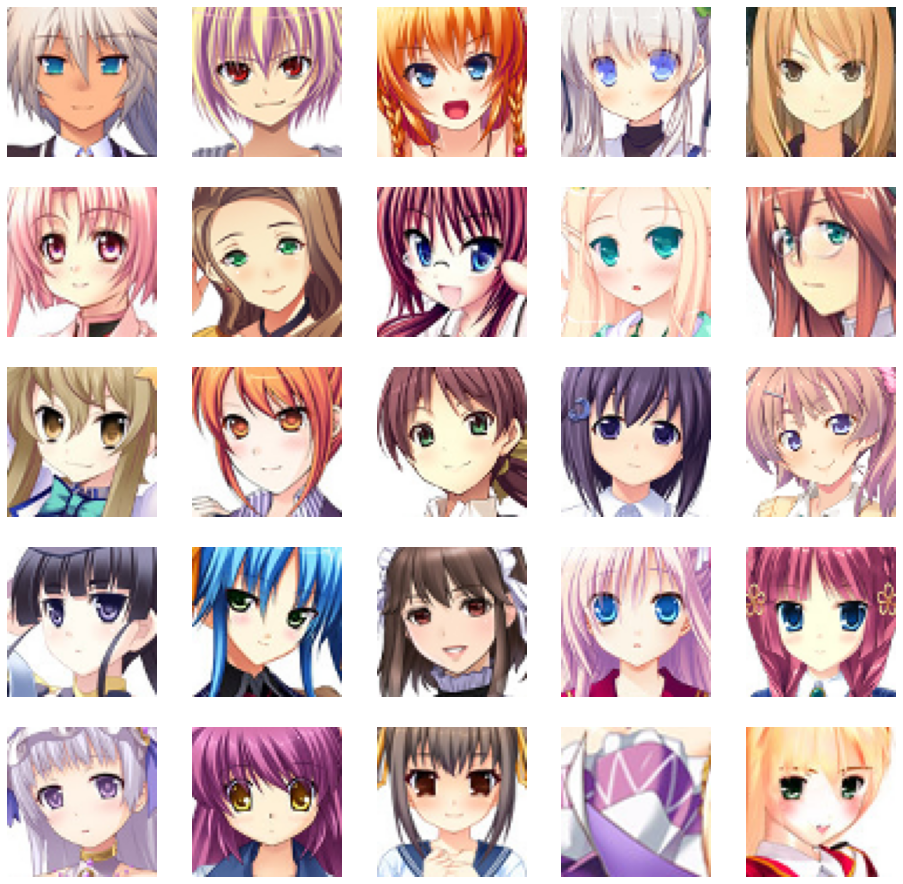

In [ ]:
_,ax = plt.subplots(5,5, figsize = (16, 16)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

In [ ]:
train_images = images.reshape(-1, img_size, img_size, channels).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

## Hyperparameter

In [ ]:
BATCH_SIZE = 256
latent_size = 16
noise_dim = 9000
buffer_size = 100000

img_shape = (img_size, img_size, channels)

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE, drop_remainder=True).shuffle(buffer_size)

## Create the models


### Spectral Normalization

In [ ]:
class SpectralNorm1D(Constraint):
  def __init__(self, output_neurons, power_iterations=1):
    assert power_iterations>=1, "The number of power iterations should be positive integer"
    self.Ip = power_iterations
    u_init = tf.random_uniform_initializer()
    self.u = tf.Variable(initial_value = u_init(shape=(1, output_neurons), dtype='float32'),
                             trainable = False)
  def __call__(self, w):
    W_mat = tf.transpose(w, (1, 0))  # (i, o) => (o, i)
    _u = self.u
    _v = None
    for _ in range(self.Ip):
      _v = l2_norm(tf.matmul(_u, W_mat))
      _u = l2_norm(tf.matmul(_v, W_mat, transpose_b=True))
    sigma = tf.reduce_sum(tf.matmul(_u, W_mat) * _v)
    sigma = tf.cond(sigma == 0, lambda: 1e-8, lambda: sigma)
    self.u.assign(tf.keras.backend.in_train_phase(_u, self.u))
    return w / sigma

In [ ]:
class SpectralNorm2D(Constraint):
  def __init__(self, output_neurons, power_iterations=1):
    assert power_iterations>=1, "The number of power iterations should be positive integer"
    self.Ip = power_iterations
    u_init = tf.random_uniform_initializer()
    self.u = tf.Variable(initial_value = u_init(shape=(1, output_neurons), dtype='float32'), trainable = False)

  def __call__(self, w):
    W_mat = tf.transpose(w, (3, 2, 0, 1))  # (h, w, i, o) => (o, i, h, w)
    W_mat = tf.reshape(W_mat, [tf.shape(W_mat)[0], -1])  # (o, i * h * w)

    _u = self.u
    _v = None

    for _ in range(self.Ip):
      _v = l2_norm(tf.matmul(_u, W_mat))
      _u = l2_norm(tf.matmul(_v, W_mat, transpose_b=True))

    sigma = tf.reduce_sum(tf.matmul(_u, W_mat) * _v)
    sigma = tf.cond(sigma == 0, lambda: 1e-8, lambda: sigma)
    self.u.assign(tf.keras.backend.in_train_phase(_u, self.u))
    return w / sigma

In [ ]:
def l2_norm(x):
  return x / tf.sqrt(tf.reduce_sum(tf.square(x)) + 1e-8)

### The Generator

In [ ]:
def make_generator_model():
    input = Input(shape=noise_dim)
    x = Dense(8*img_size*img_size, activation="relu")(input)
    x = Reshape((img_size//8, img_size//8, -1))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same",
                   use_bias=False, kernel_constraint=SpectralNorm2D(64*4))(x)
    x = InstanceNormalization(axis=3, 
                  center=True, 
                  scale=True,
                  beta_initializer="random_uniform",
                  gamma_initializer="random_uniform")(x)
    x_res = x
    # x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same", use_bias=False, kernel_constraint=SpectralNorm2D(64*4))(x)
    x = InstanceNormalization(axis=3, 
                  center=True, 
                  scale=True,
                  beta_initializer="random_uniform",
                  gamma_initializer="random_uniform")(x)
    x = Add()([x, x_res])
    x = Dropout(0.2)(x)
    x_res = x
    # x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same", use_bias=False, kernel_constraint=SpectralNorm2D(64*4))(x)
    x = InstanceNormalization(axis=3, 
                  center=True, 
                  scale=True,
                  beta_initializer="random_uniform",
                  gamma_initializer="random_uniform")(x)
    x = Add()([x, x_res])
    x = Dropout(0.2)(x)
    # x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same",
               use_bias=False, kernel_constraint=SpectralNorm2D(64*2))(x)
    x = InstanceNormalization(axis=3, 
                  center=True, 
                  scale=True,
                  beta_initializer="random_uniform",
                  gamma_initializer="random_uniform")(x)
    x_res = x
    # x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same", use_bias=False, kernel_constraint=SpectralNorm2D(64*2))(x)
    x = InstanceNormalization(axis=3, 
                  center=True, 
                  scale=True,
                  beta_initializer="random_uniform",
                  gamma_initializer="random_uniform")(x)
    x = Add()([x, x_res])
    x = Dropout(0.2)(x)
    # x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same", use_bias=False, kernel_constraint=SpectralNorm2D(64*2))(x)
    x = InstanceNormalization(axis=3, 
                  center=True, 
                  scale=True,
                  beta_initializer="random_uniform",
                  gamma_initializer="random_uniform")(x)
    # x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64*1, kernel_size=3, strides=1, padding="same",
                   use_bias=False, kernel_constraint=SpectralNorm2D(64))(x)
    x = InstanceNormalization(axis=3, 
                  center=True, 
                  scale=True,
                  beta_initializer="random_uniform",
                  gamma_initializer="random_uniform")(x)
    x_res = x
    # x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x,training=1)
    x = Conv2D(64*1, kernel_size=3, strides=1, padding="same", use_bias=False, kernel_constraint=SpectralNorm2D(64))(x)
    x = InstanceNormalization(axis=3, 
                  center=True, 
                  scale=True,
                  beta_initializer="random_uniform",
                  gamma_initializer="random_uniform")(x)
    x = Add()([x, x_res])
    x = Dropout(0.2)(x)
    x_res = x
    # x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*1, kernel_size=3, strides=1, padding="same", use_bias=False, kernel_constraint=SpectralNorm2D(64))(x)
    x = InstanceNormalization(axis=3, 
                  center=True, 
                  scale=True,
                  beta_initializer="random_uniform",
                  gamma_initializer="random_uniform")(x)
    x = Add()([x, x_res])
    # x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(channels, kernel_size=3, strides=1, padding="same", activation="tanh",
               use_bias=False)(x)
    model = Model(input, x)
    model.summary()
    return model

Use the (as yet untrained) generator to create an image.

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

generator = make_generator_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9000)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 32768)        294944768   ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 8, 8, 512)    0           ['dense[0][0]']                  
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 16, 16, 512)  0           ['reshape[0][0]']                
                                                                                              

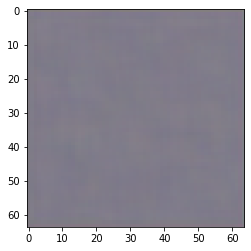

In [ ]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0, :, :, :]*127.5+127.5).astype(np.uint8))
plt.show()

### The Discriminator


In [ ]:
def make_discriminator_model():
    input = Input(shape=img_shape)
    x = Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(input)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.2)(x)
    x = Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.2)(x)
    x = Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.2)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.2)(x)
    x_res = x
    x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Add()([x_res, x])
    x = Dropout(0.2)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.2)(x)
    x_res = x
    x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Add()([x_res, x])
    x = Dropout(0.2)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.2)(x)
    x = Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.2)(x)
    x = Conv2D(1, kernel_size=1, strides=1, padding="same", use_bias=False)(x)
    x = Flatten()(x)
    x = Dense(units=1, activation=None, kernel_constraint=SpectralNorm1D(1))(x) 
    
    model = Model(input, x)
    model.summary()
    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 64)   3072        ['input_2[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 64)   0           ['conv2d_10[0][0]']              
                                                                                                  
 dropout_4 (Dropout)            (None, 32, 32, 64)   0           ['leaky_re_lu[0][0]']            
                                                                                            

In [ ]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00106213]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)

### Discriminator loss


In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Gradient Penalty

In [ ]:
def gradient_penalty(batch_size, real_images, fake_images):
  """Calculates the gradient penalty.
  This loss is calculated on an interpolated image
  and added to the discriminator loss.
  """
  # Get the interpolated image
  alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
  diff = fake_images - real_images
  interpolated = real_images + alpha * diff
  with tf.GradientTape() as gp_tape:
    gp_tape.watch(interpolated)
    # 1. Get the discriminator output for this interpolated image.
    pred = discriminator(interpolated, training=True)

  # 2. Calculate the gradients w.r.t to this interpolated image.
  grads = gp_tape.gradient(pred, [interpolated])[0]
  # 3. Calculate the norm of the gradients.
  norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
  gp = tf.reduce_mean((norm - 1.0) ** 2)
  return gp

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [ ]:
EPOCHS = 1000
num_examples_to_generate = 25

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images, gp_weight=10.0):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gp = gradient_penalty(BATCH_SIZE, images, generated_images)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output) + gp_weight*gp

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, round(time.time()-start)))

  # Generate after the final epoch
  clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(16, 16))

  dim = int(num_examples_to_generate**0.5)
  for i in range(predictions.shape[0]):
      plt.subplot(dim, dim, i+1)
      plt.imshow((predictions[i, :, :, :]*127.5+127.5).astype(np.uint8))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model

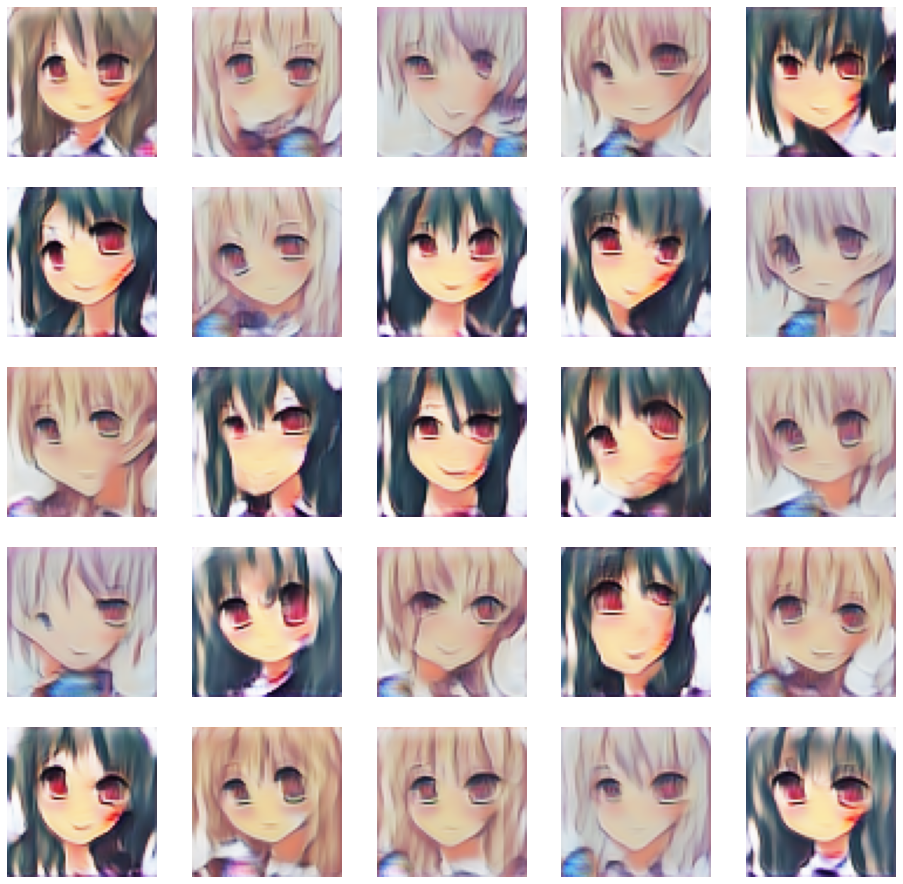

Time for epoch 130 is 112 sec


In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))